<p class="alert alert-info">
    <img class = "fa fa-info" />
    Die nachfolgenden packages
</p>

> Die nachfolgenden *packages*

# Packages
Die dzt. gängigsten Sprachen für Data Science (Python, R, Julia) lassen sich modular erweitern: Zusatzpakete bieten Funktionalitäten für bestimmte Aufgabenbereiche. Sie werden einmalig installiert oder aktualisiert und bei Bedarf *geladen*. In R heißen diese Pakete *packages*. Auf [CRAN](https://cran.r-project.org/) und [Bioconductor](https://bioconductor.org/) findet sich eine Unzahl "akkreditierter" packages. 

In [233]:
library(rio)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

In [2]:
d <- import('assets/Rohdaten.xlsx')

In [3]:
head(d)

,Abflugdatum,Abflugmonat,Abflugort,Zielort,Routing,Airline,Airlinegruppe,Mileage
,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2023-01-10,2023-01-01,Vienna (VIE),Roma (Rome) (FCO),VIE FRA FCO VIE,Lufthansa,Star Alliance,1468
2,2023-01-17,2023-01-01,Vienna (VIE),Brussels,VIE BRU VIE,Austrian Airlines,Star Alliance,1150
3,2023-01-17,2023-01-01,Copenhagen,Vienna (VIE),CPH VIE,Austrian Airlines,Star Alliance,544
4,2023-01-23,2023-01-01,Vienna (VIE),Koeln (CGN),VIE CGN VIE,Eurowings,NA,930
5,2023-01-23,2023-01-01,Vienna (VIE),Koeln (CGN),VIE CGN VIE,Eurowings,NA,930
6,2023-01-24,2023-01-01,Vienna (VIE),Copenhagen,VIE CPH,Austrian Airlines,Star Alliance,544


#### Wieviele Flugkilometer wurden insgesamt zurückgelegt?

In [4]:
d %>%
    summarise(Gesamtstrecke = sum(Mileage))

Gesamtstrecke
<dbl>
352307


<p class="alert alert-info">
    <img class = "fa fa-info" />  dasfd
</p>

#### Wieviele Meilen sind das?

In [5]:
d %>%
    summarise(Gesamtstrecke_km = sum(Mileage),
              Gesamtstrecke_Meilen = Gesamtstrecke_km / 1.6093
              )

Gesamtstrecke_km,Gesamtstrecke_Meilen
<dbl>,<dbl>
352307,218919.4


#### ein paar mehr Statistiken:

In [9]:
d %>%
    summarise(Min = min(Mileage),
              Median = median(Mileage),
              Max = max(Mileage)
             )

Min,Median,Max
<dbl>,<dbl>,<dbl>
0,644,8830


In [76]:
d %>%
    mutate(Quartal = quarter(Abflugdatum)) %>% 
    summarise(Min = min(Mileage),
              Median = median(Mileage),
              Max = max(Mileage),
              Gesamt = sum(Mileage),
              .by = Quartal
             )

Quartal,Min,Median,Max,Gesamt
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,763,8830,158652
2,0,618,3948,193655


#### Was sind die charakteristischen Flugdistanzen?

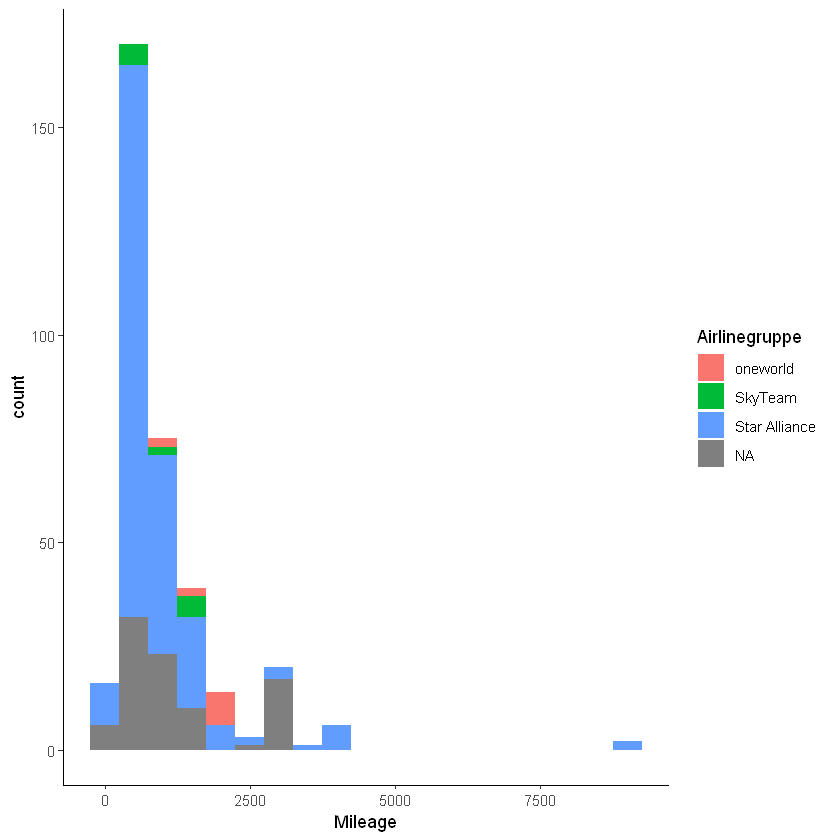

In [33]:
d %>%
    ggplot() +
        geom_histogram(aes(Mileage, fill = Airlinegruppe), binwidth = 500) +
        theme_classic()

In [7]:
d %>%
    mutate(Quartal = quarter(Abflugdatum)) %>% 
    reframe(Statistik = c('min', 'max'),
            Wert = list(min(Mileage), max(Mileage)),
            .by = Quartal
    )

Quartal,Statistik,Wert
<int>,<chr>,<list>
1,min,0
1,max,8830
2,min,0
2,max,3948


#### Was waren die Top 5 Flugziele?

In [31]:
d %>%
    filter(Abflugort == 'Vienna (VIE)') %>% 
    count(Zielort, name = 'Hinflüge') %>%
    slice_max(Hinflüge, n = 5)
    

Zielort,Hinflüge
<chr>,<int>
Brussels,22
Tbilisi,19
Copenhagen,14
Helsinki (HEL),9
Paris (CDG),8
Pristina,8


#### wie schaut das als Karte aus?

In [48]:
## library(nominatimlite)
## Koordinaten <- geo_lite(Orte) ## Orte nach Namen lokalisieren (geolocation)
## Kishnev wird nicht gefunden

In [54]:
ortsnamen_bereinigen <- function(ortsname) gsub('\\s?\\(.*\\)', '', ortsname)

In [57]:
Orte <- unique(c(d$Abflugort, d$Zielort)) %>%
    ortsnamen_bereinigen() %>% ## ersetzt "Vienna (VIE)" durch "Vienna"
    na.omit() ## enfernt fehlende Werte (NAs)

Orte %>% head(10)

[1] "Vienna"     "Copenhagen" "Pristina"   "Ankara"     "Leipzig"   
 [6] "Erevan"     "Brussels"   "Tbilisi"    "Istanbul"   "Belgrade"

In [58]:
Koordinaten <- import('assets/Koordinaten.csv')
head(Koordinaten)

,Ort,lat,lon
,<chr>,<dbl>,<dbl>
1,Vienna,48.20835,16.37250
2,Copenhagen,55.68672,12.57007
3,Pristina,42.66388,21.16408
4,Ankara,39.92078,32.85405
5,Leipzig,51.34063,12.37473
6,Erevan,40.17771,44.51262


In [20]:
library(sf)

Warning message:
"Paket 'sf' wurde unter R Version 4.1.3 erstellt"
Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 7.2.1; sf_use_s2() is TRUE



In [298]:
d_spatial <- 
    d %>%
        mutate(across(ends_with('ort'), ~ ortsnamen_bereinigen(.x))) %>% 
        left_join(Koordinaten, by = c('Abflugort' = 'Ort')) %>%
        left_join(Koordinaten, by = c('Zielort' = 'Ort'), suffix = c('_Start', '_Ziel')) %>%
        ungroup() %>% 
        filter(if_all(contains(c('lon', 'lat')), ~ !is.na(.x)))

d_spatial %>% head(3)

,Abflugdatum,Abflugmonat,Abflugort,Zielort,Routing,Airline,Airlinegruppe,Mileage,lat_Start,lon_Start,lat_Ziel,lon_Ziel
,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-01-10,2023-01-01,Vienna,Roma,VIE FRA FCO VIE,Lufthansa,Star Alliance,1468,48.20835,16.37250,41.89332,12.482932
2,2023-01-17,2023-01-01,Vienna,Brussels,VIE BRU VIE,Austrian Airlines,Star Alliance,1150,48.20835,16.37250,50.85500,4.351233
3,2023-01-17,2023-01-01,Copenhagen,Vienna,CPH VIE,Austrian Airlines,Star Alliance,544,55.68672,12.57007,48.20835,16.372504


In [303]:
library(geosphere)
d_spatial <- 
    d_spatial %>%
        rowwise() %>%
        mutate(Geodäte = gcIntermediate(cbind(lon_Start, lat_Start),
                                        cbind(lon_Ziel, lat_Ziel),
                                        n = 100, addStartEnd = TRUE, sp = TRUE
                                       ) %>%
                          st_as_sfc() %>% st_set_crs(4326)
              ) %>% 
    ungroup()

Warning message:
"There were 329 warnings in `mutate()`.
The first warning was:
i In argument: `Geodäte = `%>%`(...)`.
i In row 1.
Caused by warning:
! st_crs<- : replacing crs does not reproject data; use st_transform for that
i Run `dplyr::last_dplyr_warnings()` to see the 328 remaining warnings."


In [82]:
library(rnaturalearth)
Länder  <- ne_countries() %>% st_as_sf()

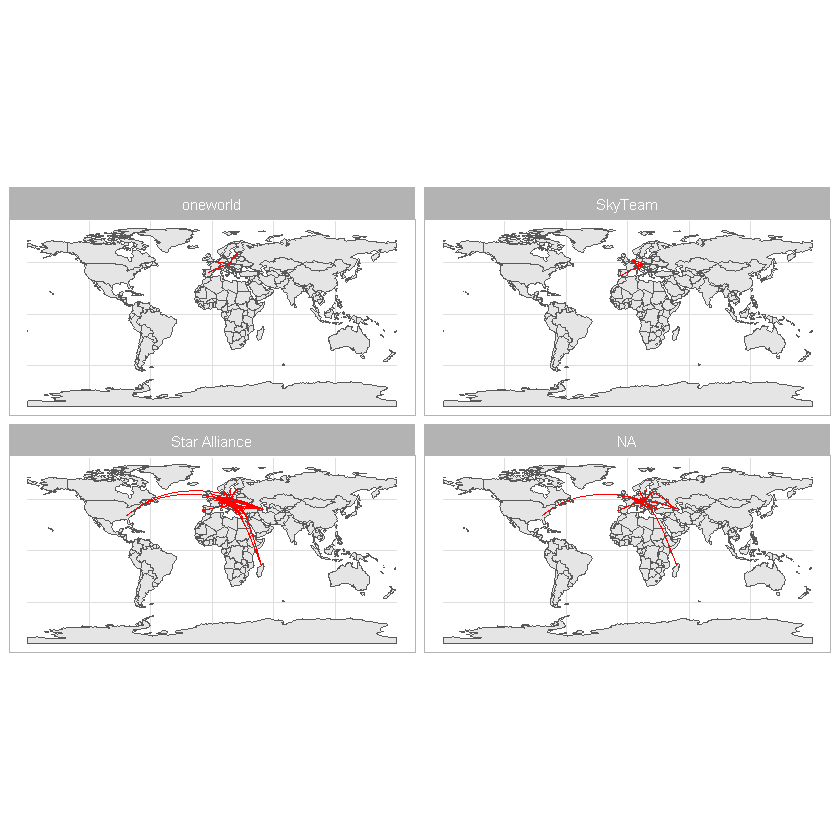

In [300]:
d_spatial %>%
    ggplot() +
        geom_sf(data = Länder) +
        geom_sf(aes(geometry = Geodäte), color = 'red') +
        facet_wrap(~ Airlinegruppe) +
        theme_light()              

bla

In [245]:
library(leaflet)
library(mapview)

Warning message:
"Paket 'mapview' wurde unter R Version 4.1.3 erstellt"


In [304]:
d_spatial_aggregated <- 
    d_spatial %>%
        summarise(Gesamtstrecke = sum(Mileage),
                  Geodäte = first(Geodäte),
                  .by = c(Abflugort, Zielort)
                 ) 

In [305]:
meine_Karte <- 
    leaflet(d_spatial_aggregated) %>%
            addProviderTiles('Stamen.Watercolor') %>% ## try 'Stamen.Terrain' or 'Stamen.Toner'
            addPolylines(data = d_spatial_aggregated$Geodäte,
                         weight = 2e-4 * d_spatial_aggregated$Gesamtstrecke
                        )

In [306]:
meine_Karte

HTML widgets cannot be represented in plain text (need html)

In [307]:
meine_Karte %>%
    mapshot(file = 'assets/meine-Karte.jpg')